In [2]:
import sys
import os
import zarr
import lilio
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

from pathlib import Path
from scipy.stats import linregress, spearmanr
from typing import Union
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.pipeline import Pipeline
from matplotlib.gridspec import GridSpec

sys.path.append(os.path.expanduser('~/Documents/Medley'))
from Medley.dataloading import get_monthly_data, prep_ecad, datapath, prep_and_resample
from Medley.utils import udomains, regions, tscolnames
from Medley.analysis import trendfit_robust
from Medley.preprocessing import Anomalizer, simultaneous_resample, makemask, average_within_mask, single_target_lagged_resample, multi_target_lagged_resample,remove_bottleneck, make_pipeline
from Medley.crossval import SpatiotemporalSplit
from Medley.estimators import return_estimator
from Medley.visualization import plot_stations, plot_plus_stations, data_for_pcolormesh
from Medley.interpretation import return_experiments, load_pred_results, return_explainer

/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
warnings.simplefilter('ignore',category=RuntimeWarning)
warnings.simplefilter('ignore',category=UserWarning)

## Timeseries
Length, data source, literature, directionality

In [7]:
preds = get_monthly_data().iloc[:,:-1] # Discarding the AMOC reconstruction because it is actually annual
# Red is drying, blue is wettening, grey = unknown.
directionality = pd.Series(['tab:blue','tab:blue','tab:blue','tab:blue', #enso 12, 3,34,4
                            'grey','grey', # amo
                            'tab:blue', # amoc
                            'tab:red','tab:red', # nao
                            'tab:red', # snao
                            'tab:red','tab:red', # ao
                            'tab:blue', # east atl
                            'grey', # pdo
                            'tab:red', # gmst
                            'tab:red','tab:blue', # mjo3, mjo6
                            'grey', # qbo
                            'tab:red','tab:red','grey','tab:blue','grey','grey', # med250 latmax, 20,30,40,50,60 
                            'grey','grey','grey','grey','grey','grey', # atl250 latmax, 20,30,40,50,60 
                            'grey','tab:red','tab:blue','grey','grey','tab:red', # med500 latmax, 20,30,40,50,60 
                            'tab:red','tab:blue','grey','grey','tab:red','tab:red', # atl500 latmax, 20,30,40,50,60 
                            'tab:red', # vortex
                            'grey','grey','grey','grey','grey','grey', # atleke latmax, 20,30,40,50,60 
                            'grey','tab:red','tab:red', # iod, west ind, east ind.
                           ],index = preds.columns)

aliases = pd.Series(['enso_12','enso_3','enso_34','enso_4', #enso 12, 3,34,4
                            'amo_ersst','amo_hadsst', # amo
                            'amoc', # amoc
                            'nao_ncep','nao_station', # nao
                            'snao_ncep', # snao
                            'ao','ao', # ao
                            'ea', # east atl
                            'pdo', # pdo
                            'gmst', # gmst
                            'mjo3','mjo6', # mjo3, mjo6
                            'qbo', # qbo
                            'u250_med_lat','u250_med_20N','u250_med_30N','u250_med_40N','u250_med_50N','u250_med_60N', # med250 latmax, 20,30,40,50,60 
                            'u250_atl_lat','u250_atl_20N','u250_atl_30N','u250_atl_40N','u250_atl_50N','u250_atl_60N', # atl250 latmax, 20,30,40,50,60 
                            'u500_med_lat','u500_med_20N','u500_med_30N','u500_med_40N','u500_med_50N','u500_med_60N', # med500 latmax, 20,30,40,50,60 
                            'u500_atl_lat','u500_atl_20N','u500_atl_30N','u500_atl_40N','u500_atl_50N','u500_atl_60N', # atl500 latmax, 20,30,40,50,60 
                            'polar_vortex', # vortex
                            'a','b','c','d','e','f', # atleke latmax, 20,30,40,50,60 
                            'iod','west_indian','east_indian', # iod, west ind, east ind.
                           ],index = preds.columns)
drop = preds.loc[:,['atl_eke']].columns
drop = drop.append(pd.MultiIndex.from_tuples([('ao',0,'ncep'), ('atl_u250_latmax',0,'era5'), ('atl_eke_latmax',0,'ERA5'),
                                             ('atl_u250', 60, 'era5')], names = drop.names))

In [8]:
preds = preds.drop(drop, axis = 1)

In [9]:
valid = ~preds.isnull()
for i, col in enumerate(valid.columns):
    valid.loc[:,col] = np.where(valid.loc[:,col], -i, np.nan)

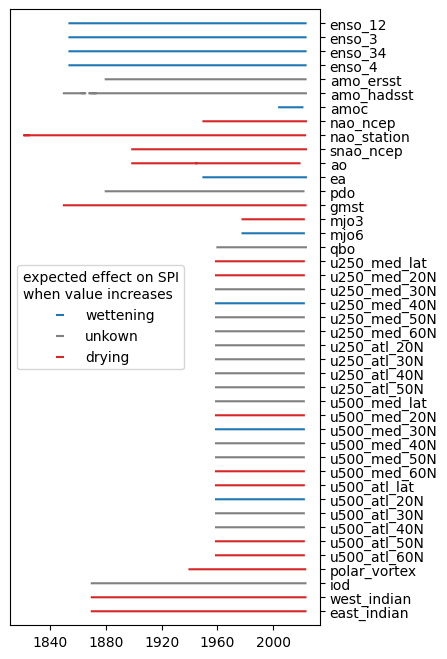

In [10]:
fig, ax = plt.subplots(figsize = (4,8))
for col in valid.columns:
    #if 'station' in col:
    #    sty = 'dashed'
    #else:
    sty = 'solid'
    ax.plot(valid.index, valid.loc[:,col], ls = sty, color = directionality.loc[col])
#valid.plot(color = 'grey', ax = ax, legend = False)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_ylim(-len(valid.columns),1)
ax.set_yticks(np.arange(0,-len(valid.columns),-1))
ax.set_yticklabels(aliases[valid.columns].values)
items = [None,None,None]
for i, color in enumerate(['tab:blue','grey','tab:red']):
    items[i] = plt.scatter([],[], color = color, marker = '_')
ax.legend(items, ['wettening','unkown','drying'], title = 'expected effect on SPI\nwhen value increases')
#plt.savefig('/scistor/ivm/jsn295/Medi/result_figs/poster/data_extent.pdf')
plt.show()

## Regions, local trend and aggregated timeseries.

In [3]:
spi_ecad = pd.read_hdf('/scistor/ivm/jsn295/Medi/monthly/eca_preaggregated_SPI3.h5')
spi_ecad.index.name = 'time'
spi_ecad_locs = pd.read_hdf('/scistor/ivm/jsn295/Medi/monthly/eca_preaggregated_SPI3_stations.h5')

In [4]:
min_count = 60 # So basically 60/3months = 20 seasons.
spi_ecad_1950 = spi_ecad.loc[slice('1950',None),:].stack().to_xarray()
# temporal subsetting to jfm
timeset = spi_ecad_1950.get_index('time').month.map(lambda m: m in list(range(4)))
spi_ecad_1950 = spi_ecad_1950.sel(time = timeset)
spi_ecad_1950.attrs['units'] = 'std'
#spi_ecad_1950.groupby(spi_ecad_1950.time.dt.year).mean()
spi_trend = trendfit_robust(spi_ecad_1950, standardize=False, min_count = min_count).sel(what = 'slope')
spi_trend = spi_trend * 10 # To std/decade
spi_trend = spi_trend.to_pandas().dropna()
#spi_trend = spi_trend.loc[spi_trend.abs().sort_values().index] # Sorting by absolute value of the trend
spi_trend = spi_trend.sort_values(ascending = False) # sorting by negativity of the trend

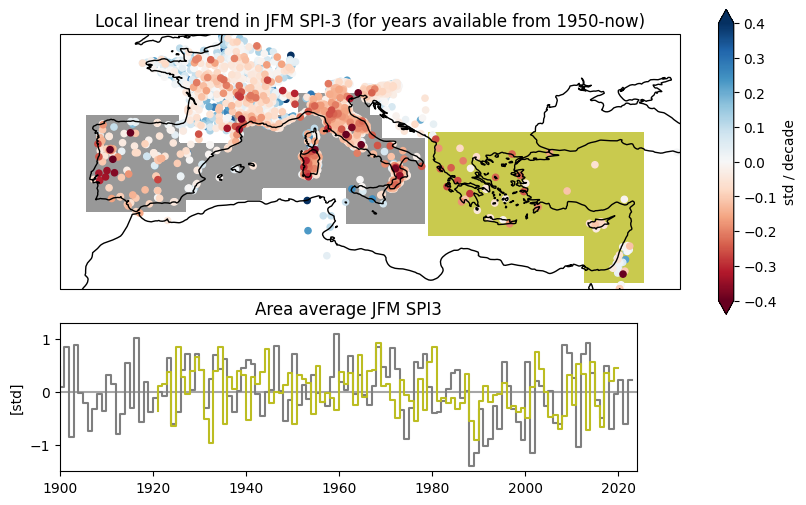

In [13]:
fig = plt.figure(figsize=(10,6),facecolor='white')

gs = GridSpec(nrows = 9, ncols=8, wspace=0.2, hspace = 0.2)
ax1 = fig.add_subplot(gs[:6,:], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[6:,:6])

shading = 'nearest'
for i, regionname in enumerate(['medwest','medeast']):
    _, y_agg, _ = prep_and_resample(target_region = regions[regionname], target_var='SPI3', minsamples = 10, 
                                    resampling = 'single', resampling_kwargs = dict(firstmonth = 1, lastmonth = 3))
    y_agg = y_agg.dropna()
    ax2.step(y_agg.index, y_agg, color = list(mcolors.TABLEAU_COLORS.keys())[i+7])
    mask = makemask(regions[regionname])
    dat = xr.where(mask, mask, np.nan)
    lat, lon, dat = data_for_pcolormesh(dat, shading = shading)
    ax1.contourf(lat, lon, dat, transform = ccrs.PlateCarree(), colors = list(mcolors.TABLEAU_COLORS.keys())[i+7], 
               alpha = 0.8)

fig, ax1, im = plot_stations(stat = spi_trend,
                            statloc=spi_ecad_locs, fig = fig, ax = ax1, 
                            cbar= True, 
                            scatter_kwargs={'s':20,#'edgecolors':'black','linewidths':0.1,
                                            'vmin': -0.4, 'vmax' : 0.4, 'cmap':'RdBu'},
                           cbar_kwargs = dict(extend = 'both', label = 'std / decade'))
ax1.set_extent((-12,40,29.5,48))
ax1.coastlines()
ax1.set_title('Local linear trend in JFM SPI-3 (for years available from 1950-now)')
ax2.set_title('Area average JFM SPI3')
ax2.set_ylabel('[std]')
ax2.set_xlim((1900,2024))
ax2.set_ylim(-1.5,1.3)
ax2.hlines(0,1900,2024, color = 'grey', alpha = 0.7, zorder = 0)
#plt.savefig('/scistor/ivm/jsn295/Medi/result_figs/poster/drying_map.pdf')
plt.show()

Picture for France and Corsica changes quite a bit if dryest trends are placed on top.

## Seasonality in target variable trends, and in its relation to predictors

In [11]:
# potential anomalization has no effect on rank correlation, because conducted per month.
preds = get_monthly_data().iloc[:,:-1] # Discarding the AMOC reconstruction because it is actually annual
preds = preds.drop(drop, axis = 1)

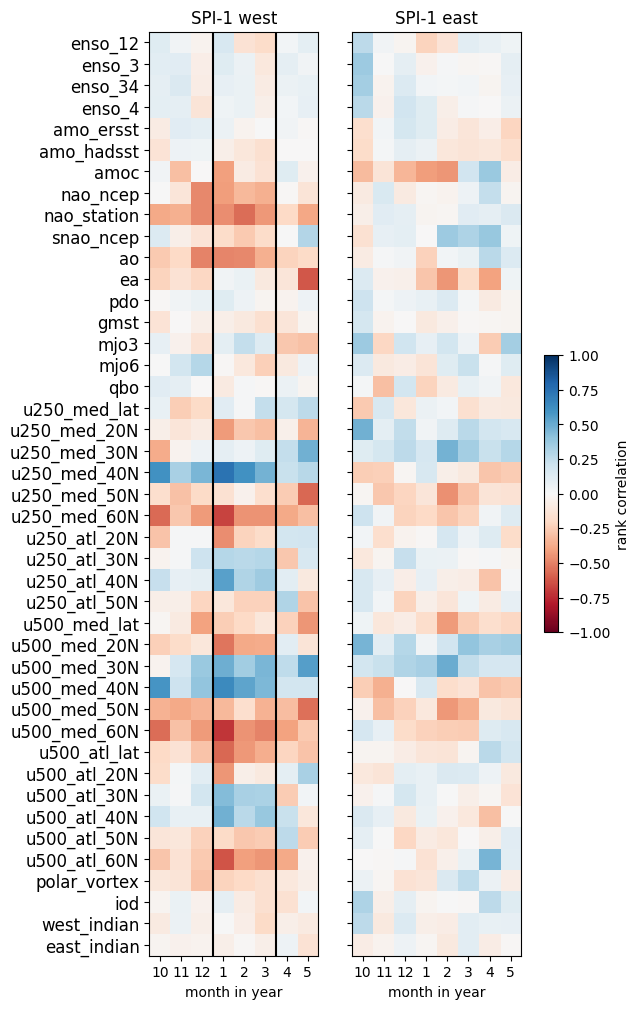

In [16]:
fig, axes = plt.subplots(figsize = (6,12), ncols = 2, sharey = True, sharex = True)
for i, regionname in enumerate(['medwest','medeast']):
    # cannot use prep-and resample, because that is always lagged.
    target = prep_ecad(target_region=regions[regionname], target_var = 'SPI1').to_frame()
    target.columns = pd.MultiIndex.from_tuples([('SPI1',0,'ECAD')], names = tscolnames)
    Xres, yres, _ = simultaneous_resample(X = preds, y = target, firstmonth = 1, lastmonth = 1, average = False)
    # Plotting correlations per month, single months
    months = [10,11,12,1,2,3,4,5]
    othervars = Xres.columns
    corrcoefs = xr.DataArray(np.full((len(othervars),len(months)),np.nan), dims = ('variables','month'),
                            coords = {'month':months, 'variables':othervars}, name = 'spearmanr')
    for month in months:
        Xres, yres, _ = simultaneous_resample(X = preds, y = target, firstmonth = month, lastmonth = month, average = False)
        for var in othervars:
            dat = Xres.loc[:,[var]].join(yres, how = 'inner').dropna(how = 'any')
            corrcoefs.loc[var,month] = spearmanr(dat)[0]
    ax = axes[i]
    im = ax.imshow(corrcoefs.values, vmin = -1, vmax = 1, cmap = 'RdBu', aspect = 'auto')
    ax.set_title(f'SPI-1 {regionname[3:]}')
    if i == 0:
        ax.set_yticks(np.arange(corrcoefs.shape[0]))
        ax.set_yticklabels(aliases[corrcoefs.indexes['variables']].values, size = 12)
        ax.vlines([2.5,5.5], ymin = -0.5, ymax = corrcoefs.shape[0] - 0.5, color = 'black')
    ax.set_xlabel('month in year')
    ax.set_xticks(np.arange(corrcoefs.shape[1]))
    ax.set_xticklabels(corrcoefs.indexes['month'].values)

#plt.setp(ax.get_xticklabels(), rotation=80, ha="right",
#         rotation_mode="anchor")
fig.colorbar(im, ax = axes, label = 'rank correlation', shrink = 0.3)
#plt.savefig('/scistor/ivm/jsn295/Medi/result_figs/poster/seasonal_correlation.pdf')
plt.show()

## Predictor selection, directionality and accuracy for several models
both eastern and western med

In [20]:
east_med_exps = ['2e2320856f','f15adcb93d'] # ridge regression (mae), random forest (mae) both 1950 onwards
west_med_exps = ['7a000e2f64','deb4021d58'] # ridge (mae), rf regression (r2)  # '627ee28dd0' could be an option but is single (so scores are not comparable)
exps = {'west':west_med_exps,'east':east_med_exps}

In [21]:
max_npredictors = 7
npredictors = pd.RangeIndex(1, max_npredictors + 1, name = 'npredictors')
collection = {}
for regionname, region_exps in exps.items():
    # Loading of experiment log
    exp_dicts = return_experiments(region_exps)
    # Preallocation of objects to capture results
    r2 = pd.DataFrame(np.nan, index = npredictors, columns = exp_dicts.keys())
    nmse = r2.copy(deep = True)
    attributions = {}
    estimators = {}
    for expid, experiment in exp_dicts.items():
        """ recreation of experiments could be wrapped into function """
        Xm, ym, cal = prep_and_resample(**experiment['prep_kwargs'])
        Xm, ym = remove_bottleneck(Xm, ym, **experiment['bottleneck_kwargs'])
        result, cv_scores = load_pred_results(expid) 
        modelclass = return_estimator(experiment['estimator']) 
        model = modelclass(**experiment['estimator_kwargs'])
        cv_kwargs = experiment['cv_kwargs']
        cv_kwargs['time_dim'] = Xm.index
        cv = SpatiotemporalSplit(**cv_kwargs)
        if experiment['pipeline_kwargs']:
            model = make_pipeline(estimator = model, **experiment['pipeline_kwargs'])
        """ until here """
        attr = {}
        for npreds in npredictors:
            if npreds in result.index:
                prednames = result.loc[npreds,'feature_names']
                subset = Xm[list(prednames)]
                # Getting CV scores
                scores = cross_validate(model, X = subset, y = ym.squeeze(), cv = cv, scoring = ['r2','neg_mean_squared_error'])
                r2.loc[npreds, expid] = scores['test_r2'].mean()
                nmse.loc[npreds, expid] = scores['test_neg_mean_squared_error'].mean()
                # Getting directionality (when everything is training data?)
                model.fit(X = subset, y = ym.squeeze())
                # return_explainer deals with pipelines as well. Median (over all samples) of the attribution is probably suboptimal for random forests
                expl = return_explainer(model)
                attr.update({npreds:expl.explain(X = subset)})
        attr = pd.concat(attr).unstack(0)
        attr.columns = attr.columns.set_names(['npredictors'])
        attributions.update({expid:attr})
        estimators.update({expid:experiment['estimator']})
    collection.update({regionname:(r2,nmse,attributions,estimators)})

dropping predictors: MultiIndex([(         ('amoc', 0, 'rapid'), -2),
            (         ('amoc', 0, 'rapid'), -1),
            (           ('mjo', 3, 'ncep'), -2),
            (           ('mjo', 3, 'ncep'), -1),
            (           ('mjo', 6, 'ncep'), -2),
            (           ('mjo', 6, 'ncep'), -1),
            (('atl_eke_latmax', 0, 'ERA5'), -2),
            (('atl_eke_latmax', 0, 'ERA5'), -1),
            (      ('atl_eke', 20, 'ERA5'), -2),
            (      ('atl_eke', 20, 'ERA5'), -1),
            (      ('atl_eke', 30, 'ERA5'), -2),
            (      ('atl_eke', 30, 'ERA5'), -1),
            (      ('atl_eke', 40, 'ERA5'), -2),
            (      ('atl_eke', 40, 'ERA5'), -1),
            (      ('atl_eke', 50, 'ERA5'), -2),
            (      ('atl_eke', 50, 'ERA5'), -1),
            (      ('atl_eke', 60, 'ERA5'), -2),
            (      ('atl_eke', 60, 'ERA5'), -1)],
           names=['variables', 'i_interval'])
samples left: 175
features left: 86
dropping predi

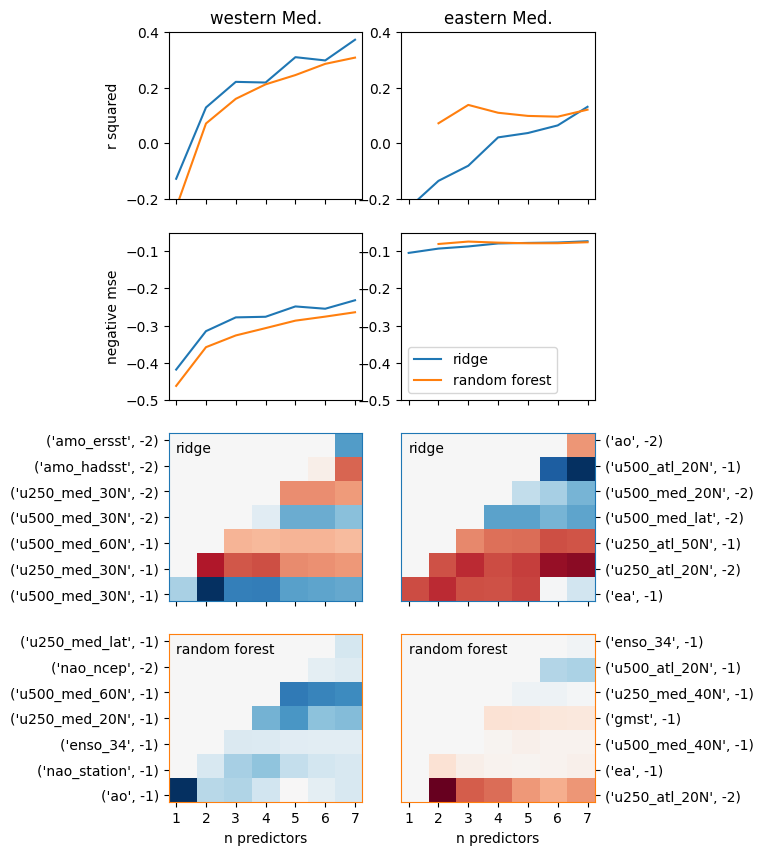

In [28]:
fig, axes = plt.subplots(4,2, squeeze = False, figsize = (5.5,10), sharex = True, sharey = False)
for j, regionname in enumerate(exps.keys()):
    r2, nmse, attributions, estimators = collection[regionname]
    for i, expid in enumerate(attributions.keys()):
        axes[0,j].plot(r2[expid].index,r2[expid].values)
        axes[1,j].plot(nmse[expid].index,nmse[expid].values, label = 'ridge' if estimators[expid].startswith('rid') else 'random forest')
        data = attributions[expid].reindex(columns = npredictors)
        first_selected = data.count(axis = 1).sort_values(ascending = False)
        data = data.loc[first_selected.index,:]
        data = data.fillna(0)
        vmax = max(data.max(axis = None), abs(data.min(axis = None)))
        #axes[2+i,j].set_facecolor('white')
        axes[2+i,j].imshow(data, cmap = 'RdBu', aspect = 'auto', vmin = -vmax, vmax = vmax,
                         extent = (0.75,max_npredictors+.25,0.75,max_npredictors+.25), origin = 'lower')
        
        for location in ['bottom','top','right','left']:
            axes[2+i,j].spines[location].set_color(list(mcolors.TABLEAU_COLORS.keys())[i])
        
        if j == 1:
            axes[2+i,j].yaxis.set_label_position("right")
            axes[2+i,j].yaxis.tick_right()
        axes[2+i,j].set_yticks(npredictors.values)
        aliasindex = pd.MultiIndex.from_arrays([aliases[data.index.get_level_values(0)].values, data.index.get_level_values(1)])
        axes[2+i,j].set_yticklabels(aliasindex.to_flat_index())
        axes[2+i,j].text(1, max_npredictors - 0.5,'ridge' if estimators[expid].startswith('rid') else 'random forest',)
    
    axes[-1,j].set_xticks(npredictors)
    axes[-1,j].set_xlabel('n predictors')
    axes[0,j].set_title(f'{regionname}ern Med.')
    axes[0,j].set_ylim(-0.2,0.4)
    axes[1,j].set_ylim(-0.5,-0.05)
axes[0,0].set_ylabel('r squared')
axes[1,0].set_ylabel('negative mse')
axes[1,1].legend()
plt.savefig('/scistor/ivm/jsn295/Medi/result_figs/poster/predictor_selection.pdf')
plt.show()

## Just western Med, Xgboost and an RF result
specifically for the Deliverable

In [38]:
npredictors = pd.Index([2,4,6,8,10,12] + list(range(14,89,4)), name = 'npredictors')
expid = ['fa83d256b8','dd0d579f41']
# Best rf exps: 2a0c4a17ce = -0.351 (nmse), 3ecf1388d4 = 0.072 (r2), fa83d256b8 = -0.375 (nmse)

In [39]:
exp_dicts = return_experiments(expid)
# Preallocation of objects to capture results
r2 = pd.DataFrame(np.nan, index = npredictors, columns = exp_dicts.keys())
nmse = r2.copy(deep = True)
estimators = {}

for expid, experiment in exp_dicts.items():
    """ recreation of experiments could be wrapped into function """
    experiment['prep_kwargs'].update({'target_region':regions[experiment['region_name']]})
    Xm, ym, cal = prep_and_resample(**experiment['prep_kwargs'])
    Xm, ym = remove_bottleneck(Xm, ym, **experiment['bottleneck_kwargs'])
    result, cv_scores = load_pred_results(expid) 
    modelclass = return_estimator(experiment['estimator']) 
    # adding some more jobs
    experiment['estimator_kwargs'].update({'n_jobs':15})
    model = modelclass(**experiment['estimator_kwargs'])
    cv_kwargs = experiment['cv_kwargs']
    cv_kwargs['time_dim'] = Xm.index
    cv = SpatiotemporalSplit(**cv_kwargs)
    if experiment['pipeline_kwargs']:
        model = make_pipeline(estimator = model, **experiment['pipeline_kwargs'])
    """ until here """
    for npreds in npredictors:
        if npreds in result.index:
            prednames = result.loc[npreds,'feature_names']
            subset = Xm[list(prednames)]
            # Getting CV scores
            scores = cross_validate(model, X = subset, y = ym.squeeze(), cv = cv, scoring = ['r2','neg_mean_squared_error'])
            r2.loc[npreds, expid] = scores['test_r2'].mean()
            nmse.loc[npreds, expid] = scores['test_neg_mean_squared_error'].mean()

    estimators.update({expid:experiment['estimator']})

dropping predictors: MultiIndex([(         ('amoc', 0, 'rapid'), -2),
            (         ('amoc', 0, 'rapid'), -1),
            (           ('mjo', 3, 'ncep'), -2),
            (           ('mjo', 3, 'ncep'), -1),
            (           ('mjo', 6, 'ncep'), -2),
            (           ('mjo', 6, 'ncep'), -1),
            (('atl_eke_latmax', 0, 'ERA5'), -2),
            (('atl_eke_latmax', 0, 'ERA5'), -1),
            (      ('atl_eke', 20, 'ERA5'), -2),
            (      ('atl_eke', 20, 'ERA5'), -1),
            (      ('atl_eke', 30, 'ERA5'), -2),
            (      ('atl_eke', 30, 'ERA5'), -1),
            (      ('atl_eke', 40, 'ERA5'), -2),
            (      ('atl_eke', 40, 'ERA5'), -1),
            (      ('atl_eke', 50, 'ERA5'), -2),
            (      ('atl_eke', 50, 'ERA5'), -1),
            (      ('atl_eke', 60, 'ERA5'), -2),
            (      ('atl_eke', 60, 'ERA5'), -1)],
           names=['variables', 'i_interval'])
samples left: 169
features left: 88
dropping predi

Text(0.5, 0.98, 'Performance of statistical prediction of Western Mediterranean SPI1 in JFM')

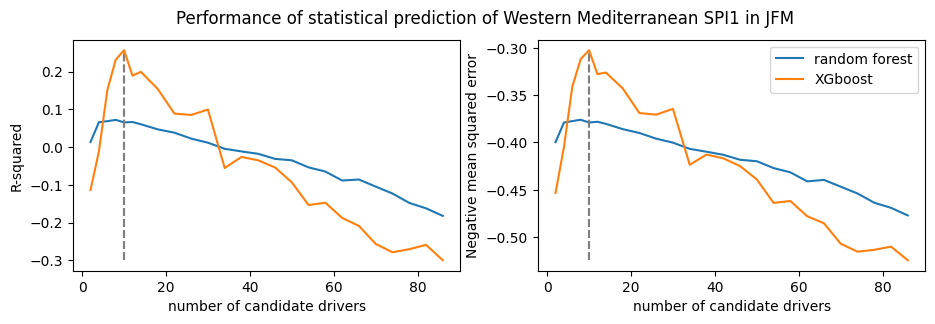

In [56]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, squeeze = False, figsize = (11,3), sharex = True, sharey = False)
for i, (expid, estimatorname) in enumerate(estimators.items()):
    for j, data in enumerate([r2,nmse]):
        axes[0,j].vlines(x = 10, ymin = data.min(axis = None), ymax = data.max(axis = None), color = 'grey', ls = '--')
        axes[0,j].plot(data[expid].index,data[expid].values, label = 'random forest' if estimatorname.startswith('rf') else 'XGboost')
        axes[0,j].set_xlabel('number of candidate drivers')
        
axes[0,1].legend()
axes[0,0].set_ylabel('R-squared')
axes[0,1].set_ylabel('Negative mean squared error')    
    
fig.suptitle('Performance of statistical prediction of Western Mediterranean SPI1 in JFM')

In [60]:
result.loc[10,'feature_names'] # Top predictors

((('ao', 0, 'ncep'), -2),
 (('pdo', 0, 'ersstv5'), -1),
 (('med_u250_latmax', 0, 'era5'), -2),
 (('med_u250', 30, 'era5'), -1),
 (('med_u250', 60, 'era5'), -2),
 (('med_u250', 60, 'era5'), -1),
 (('atl_u250_latmax', 0, 'era5'), -2),
 (('med_u500', 30, 'era5'), -2),
 (('med_u500', 30, 'era5'), -1),
 (('iod', 0, 'hadisst'), -1))

In [61]:
Xm

variables                (enso, 12, ersstv5)           (enso, 3, ersstv5)  \
i_interval                                -2        -1                 -2   
anchor_year anchor_month                                                    
1960        3                       0.007665 -0.030644          -0.043245   
1961        1                      -0.319950 -0.121552          -0.620648   
            2                      -0.121552  0.243527          -0.457328   
            3                       0.243527  0.875705          -0.392997   
1962        1                      -0.279257 -0.654634          -0.349618   
...                                      ...       ...                ...   
2015        2                       0.026289 -0.455404           0.495904   
            3                      -0.455404 -0.795968           0.084606   
2016        1                       1.756310  1.609050           2.598240   
            2                       1.609050  1.008470           2.561070   
            3                       1.008470  0.801640           2.190730   

variables                          (enso, 34, ersstv5)            \
i_interval                      -1                  -2        -1   
anchor_year anchor_month                                           
1960        3            -0.223641            0.041238 -0.190163   
1961        1            -0.457328           -0.002236 -0.088799   
            2            -0.392997           -0.088799 -0.079735   
            3            -0.010113           -0.079735  0.024448   
1962        1            -0.268752           -0.110290 -0.230600   
...                            ...                 ...       ...   
2015        2             0.084606            0.522193  0.284876   
            3            -0.273538            0.284876  0.234752   
2016        1             2.561070            2.458170  2.348880   
            2             2.190730            2.348880  2.120310   
            3             1.678740            2.120310  1.996820   

variables                (enso, 4, ersstv5)           (amo, 0, ersstv5)  \
i_interval                               -2        -1                -2   
anchor_year anchor_month                                                  
1960        3                     -0.423890 -0.489973          0.066493   
1961        1                      0.181567  0.328904          0.199047   
            2                      0.328904 -0.026329         -0.051200   
            3                     -0.026329 -0.154842          0.041641   
1962        1                     -0.003581 -0.059448          0.302625   
...                                     ...       ...               ...   
2015        2                      0.750322  0.789361          0.092850   
            3                      0.789361  1.016980          0.054117   
2016        1                      1.105710  0.943056         -0.312498   
            2                      0.943056  0.610412         -0.233892   
            3                      0.610412  0.846932         -0.069132   

variables                           ... (vortex_u20, 7080, era5)             \
i_interval                      -1  ...                       -2         -1   
anchor_year anchor_month            ...                                       
1960        3             0.016750  ...                 8.260654  16.378693   
1961        1            -0.051200  ...                 9.620138  15.702300   
            2             0.041641  ...                15.702300  17.200035   
            3             0.039658  ...                17.200035  31.946287   
1962        1             0.355386  ...                14.992079  21.853781   
...                            ...  ...                      ...        ...   
2015        2             0.054117  ...                26.481932  20.951139   
            3            -0.070623  ...                20.951139  28.773359   
2016        1            -0.233892  ...         